# テスト理論（スコアリング）

## 概要

「英語力」や「トンネルの劣化度合い」など、 何らかの概念上の値を測りたいとする。

「身長」「体重」のような物理的に測定できるものとは異なり、これらの概念的なスコアは直接測ることはできない。
そこでテストの設問や調査の項目を複数用意して測っていくことになり、それらの項目の点数をどのように集約して扱いやすいスコアを算出するかが課題となり、テスト理論の出番となる。



## スコアリングの流れ

1. 項目作成（テストの作成）
2. 項目分析（予備的に調査 or 本調査して使えるデータか検討）
3. 項目パラメータの推定・等化
4. テストの編集
5. テストスコアの算出

## テスト理論のパラダイム

**古典テスト理論** と呼ばれる考えかたと、より新しい **項目反応理論** がある。


### 古典テスト理論

古典テスト理論では、観測した得点$z$は真の得点$\mu$と測定誤差$e$によって構成されると考える。

$$
z = \mu + e
$$

誤差は過大評価も過小評価もありえて、平均が0になる確率変数$E[e]=0$と仮定する。


### 古典テスト理論の限界

:::{card} 例：学力調査

同じテストを学校Aと学校Bで実施した。

- 学校AのXさんの偏差値が50
- 学校BのYさんの偏差値が55

Yさんの学力がXさんより上と言えるか？

→ 点数を偏差値に変換しても、学校ごとに学力分布が異なる場合は直接比較はできない
:::

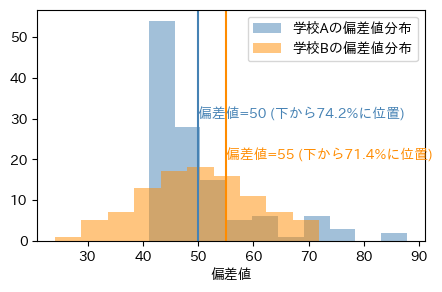

In [2]:
import numpy as np

class ScoreTransformer:
    def __init__(self, arr: np.ndarray):
        self.mean = np.mean(arr)
        self.std = np.std(arr)

    def transform(self, arr: np.ndarray) -> np.ndarray:
        return (arr - self.mean) / self.std * 10 + 50

    def inverse_transform(self, t_scores: np.ndarray) -> np.ndarray:
        return (t_scores - 50) / 10 * self.std + self.mean


import matplotlib.pyplot as plt
import matplotlib_fontja
from scipy.stats import norm, lognorm

def to_deviation(x: np.ndarray) -> np.ndarray:
    return (x - np.mean(x)) / np.std(x) * 10 + 50

# 学校A
d1 = lognorm(s=1)
raw1 = d1.rvs(size=120, random_state=0)
st1 = ScoreTransformer(raw1)
y1 = st1.transform(raw1)

# 学校B
d2 = norm(loc=0, scale=1)
raw2 = d2.rvs(size=100, random_state=0)
st2 = ScoreTransformer(raw2)
y2 = st2.transform(raw2)

# 点数
score_x = 50
score_y = 55

# どこに位置するか
raw_x = st1.inverse_transform(np.array([score_x]))[0]
q1 = d1.cdf(raw_x)
raw_y = st2.inverse_transform(np.array([score_y]))[0]
q2 = d2.cdf(raw_y)

fig, ax = plt.subplots(figsize=[5, 3])
ax.hist(y1, label="学校Aの偏差値分布", alpha=0.5, color="steelblue")
ax.axvline(score_x, color="steelblue")
ax.text(score_x, 30, f"偏差値={score_x} (下から{q1:.1%}に位置)", color="steelblue")
ax.hist(y2, label="学校Bの偏差値分布", alpha=0.5, color="darkorange")
ax.axvline(score_y, color="darkorange")
ax.text(score_y, 20, f"偏差値={score_y} (下から{q2:.1%}に位置)", color="darkorange")
ax.set(xlabel="偏差値")
ax.legend()
fig.show()

偏差値と同様に、古典テスト理論は項目の難易度（テストの難しさ）と受験者の能力の分布の影響が分離ができないので、異なる集団間の受験者の能力を比較可能にできない。

:::{card} テスト理論における用語

- **素点** （row score, そてん, **粗点** とも）：テストの問題ごとの配点の点数。
- テスト得点の **集団依存性（group dependence）** （ **標本依存性（sample dependence）** とも） ：テスト得点（素点の合計）がテストを受けた集団に依存すること。例えば同じ試験でも優秀な学生たちが解くのとそうでない学生たちが解いたのでは集団の平均点が変わる。
- テスト得点の **項目依存性（item dependence）** ：テストの平均点が個々のテスト項目の難易度に影響されること。
- **等化（equating）** ：異なるテストの結果を比較可能にする手続き。IRTを使っても等化の手続きは必要になる

古典テスト理論では集団依存性や項目依存性の問題を解決できない

:::

### 項目反応理論

**項目反応理論 （item response theory: IRT）** は受験者の能力と項目の難しさを別々に推定することが可能な理論。

例えば以下のようなモデルを使用する。回答者$i$の項目$j$への正答確率について以下のように表すモデルを構築する

$$
P(y_{ij} = 1) = \operatorname{logit}^{-1}(a_j (\theta_i - b_j)) = \frac{1}{1+\exp(-a_j (\theta_i - b_j))}
$$

ここで

- $\theta_i$ ： **達成度 (achievement)** や **潜在特性 (trait)** と呼ばれるパラメータ（$\theta_i \sim \mathcal{Normal}(0,1)$）
- $a_j$ ： **識別力 (discrimination)** と呼ばれるパラメータ
- $b_j$ ： **困難度(difficulty)** と呼ばれるパラメータ

上記のモデルは2パラメータロジスティックモデル（2PL）というモデルで、他にも3PLなど様々なモデルが存在する。


項目反応理論はTOEIC, TOEFL, PISA, SATなど様々なテストで用いられている。例えばTOEICは毎回の試験で異なる設問項目で構成されるが、TOEICのスコアの価値は等しくなるよう設計されている。


:::{margin}

学習の達成度などを測るための項目反応理論に対して、学習状況を測るテスト理論の **認知診断モデル（cognitive diagnostic model; CDM）** というものもあるらしい

[２つのテスト理論 ―項目反応モデルと認知診断モデル―](https://jartest.jp/meeting/19th_data/rec_3_okada.pdf)
:::

## 参考

- [Chapter 8 項目反応理論 1](https://www2.kobe-u.ac.jp/~bunji/files/lecture/MVA/mva-08-item-response-theory.pdf)
- [usami-lab.com/教育心理学会チュートリアル2018資料.pdf](https://usami-lab.com/%E6%95%99%E8%82%B2%E5%BF%83%E7%90%86%E5%AD%A6%E4%BC%9A%E3%83%81%E3%83%A5%E3%83%BC%E3%83%88%E3%83%AA%E3%82%A2%E3%83%AB2018%E8%B3%87%E6%96%99.pdf)